# Projet final Machine learning for Time series :

### Testing MSDL for synthetic data :

### Testing MSDL for FMRI data :

In [3]:
# imports
import nilearn
from nilearn import datasets
from nilearn import plotting
from nilearn.image import mean_img
import pandas as pd
from nilearn import image, plotting
import numpy as np
from nilearn.input_data import NiftiMasker
from nilearn.image import concat_imgs
from nilearn.decomposition import CanICA
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.stats import binom


# https://nilearn.github.io/dev/modules/generated/nilearn.datasets.fetch_atlas_msdl.html#nilearn.datasets.fetch_atlas_msdl


In [4]:
# Charger un dataset (par exemple : données de resting-state)
dataset = datasets.fetch_development_fmri(n_subjects=20)
fmri_files = dataset.func  # Chemins vers les fichiers fMRI
confounds = dataset.confounds  # Informations supplémentaires pour correction


[get_dataset_dir] Dataset found in C:\Users\Sara Meziane\nilearn_data\development_fmri
[get_dataset_dir] Dataset found in C:\Users\Sara Meziane\nilearn_data\development_fmri\development_fmri
[get_dataset_dir] Dataset found in C:\Users\Sara Meziane\nilearn_data\development_fmri\development_fmri


In [5]:
# Créer un masque standard du cerveau
masker = NiftiMasker(smoothing_fwhm=6, standardize=True, detrend=True, mask_strategy='epi')

# concaténation des images  
fmri_4d = concat_imgs(fmri_files)

# Appliquer le masque pour extraire les séries temporelles
time_series = masker.fit_transform(fmri_4d)


In [6]:
# Centrer et normaliser les séries temporelles
time_series_normalized = (time_series - np.mean(time_series, axis=0)) / np.std(time_series, axis=0)


C:\Users\Sara Meziane\AppData\Local\Temp\ipykernel_19264\840580327.py:5: FutureWarning: The nifti_maps_masker_ attribute is deprecated andwill be removed in Nilearn 0.11.3. Please use maps_masker_ instead.
  canica.fit(fmri_files)


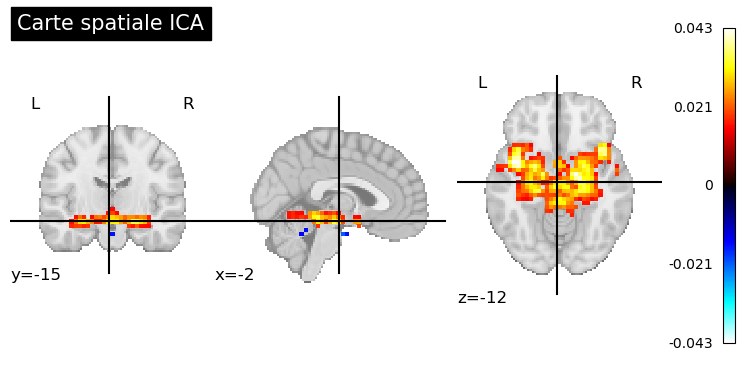

In [7]:
# Initialiser un modèle ICA
canica = CanICA(n_components=40, mask=masker.mask_img_, random_state=0)

# Ajuster le modèle aux données
canica.fit(fmri_files)

# Extraire les cartes spatiales
components_img = canica.components_img_
first_component_img = index_img(components_img, 0)

# Visualiser une composante
plot_stat_map(first_component_img, title="Carte spatiale ICA", display_mode="ortho")

### Functions :

In [22]:
"""
def adjacency_gaussian(X, sigma=1.0):
    
    Construct a Gaussian adjacency matrix based on distances.

    Parameters:
        X (numpy.ndarray): Points in space (n_points x n_features).
        sigma (float): Gaussian width.

    Returns:
        A (numpy.ndarray): Adjacency matrix.
    
    distances = squareform(pdist(X))  
    A = np.exp(-distances**2 / (2 * sigma**2))
    return A



def compute_normalized_laplacian(X):
    
    Compute the normalized Laplacian matrix from an adjacency matrix.

    Parameters:
        X (numpy.ndarray): Points in space (n_points x n_features)

    Returns:
        L_norm (numpy.ndarray): Normalized Laplacian matrix (p x p).
    
    A = adjacency_gaussian(X)
    D = np.diag(np.sum(A, axis=1))  # Degree matrix
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))  # Inverse square root of degree matrix
    L_norm = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    return L_norm
"""

def compute_normalized_laplacian(grid_length):
    # Création de la matrice laplacienne pour une grille 1D
    e = np.ones(grid_length)
    laplacian_1d = np.diag(2 * np.ones(grid_length)) - np.diag(np.ones(grid_length - 1), k=1) - np.diag(np.ones(grid_length - 1), k=-1)
        
    # Création de la matrice laplacienne pour une grille 2D
    I = np.eye(grid_length)
    laplace_2d = np.kron(I, laplacian_1d) + np.kron(laplacian_1d, I)
    return laplace_2d    

def soft_thresholding(x, threshold):
    """
    Element-wise soft-thresholding operator.
    s_κγ(x) = sign(x) * max(abs(x) - threshold, 0)
    """
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def proximal_operator_smooth_lasso(v, L, gamma, kappa, n_iter=100):
    """
    Proximal operator for the smooth-lasso with FISTA.
    
    Parameters:
        v: numpy array, spatial map input.
        L: numpy array, Laplacian operator (matrix or regularization operator).
        gamma: float, regularization parameter for smoothness.
        kappa: float, regularization parameter for sparsity.
        k: int, number of iterations.

    Returns:
        v_star: numpy array, denoised spatial map.
    """
    # Initialization
    z = v.copy()
    v_star = v.copy()
    tau = 1
    #assert 0 < kappa < (1 + gamma * np.linalg.norm(L))**-1, "Invalid value for kappa."

    for _ in range(n_iter):
        v_old = v_star.copy()
        # Update v_star using soft-thresholding
        v_star = soft_thresholding(z - kappa * (z - v + gamma * L @ z), kappa * gamma)
        # Update τ
        tau_new = (1 + np.sqrt(1 + 4 * tau**2)) / 2
        # Update z
        z = v_star + ((tau - 1) / tau_new) * (v_star - v_old)
        tau = tau_new
    return v_star

def compute_energy(Y, U, Vs, V, L ,mu, lambd):
    """
    Compute the energy of the MSDL model.
    
    Parameters:
        Y: numpy array s*n*p, time series for each subject.
        U: numpy array s*n*k, subject level time series.
        Vs: numpy array s*p*k, subject level spatial maps.
        V: numpy array p*k, group level spatial maps.
        mu: float, regularization parameter for the subject level spatial maps.
        lambd: float, regularization parameter for the group level spatial maps.

    Returns:
        energy: float, energy value.
    """
    S, n, p = Y.shape
    k = V.shape[1]
    energy = 0
    for s in range(S):
        residual = np.linalg.norm(Y[s] - U[s] @ Vs[s].T, "fro") ** 2
        penalty_Vs = mu * np.linalg.norm(Vs[s] - V, "fro") ** 2
        energy += 0.5 * (residual + penalty_Vs)

    for h in range(k):
        energy += lambd * (0.5 * V[:, h].T @ L @ V[:, h])
    energy += lambd * (np.linalg.norm(V, ord=1, axis=None))
    return energy

def MSDL_solving(Y, k , V_init , mu , lambd, epsilon=1e-4,max_iter=100):
    """
    This function applies the optimization algorithm described in the paper.
    
    Parameters:
        Y: numpy array s*n*p, time series for each subject.
        k : int, number of time points.
        num_maps: int, number of spatial maps.
        epsilon : float, convergence threshold.
        V_init : numpy array p*k, initial spatial maps.

    Returns:
        V : numpy array p*k, group level spatial maps.
        Vs : numpy array s*p*k, subject level spatial maps.
        Us : numpy array s*n*k, subject level time series.
    """
    E = []  # InitialEnergy values
    S,n,p = Y.shape
    i = 1
    Vs = V_init

    # Initializaton of Us and V_s
    V = V_init
    U = np.zeros((S,n,k))
    Vs = np.zeros((S,p,k))
    for s in range(S):
        U[s] = Y[s]@V_init@np.linalg.inv(V_init.T@V_init)
        Vs[s] = V_init
    L = compute_normalized_laplacian(int(np.sqrt(p)))
    E.append(compute_energy(Y, U, Vs, V, L ,mu, lambd)**2)
    E.append(compute_energy(Y, U, Vs, V, L ,mu, lambd))
    
    # Optimization loop
    while (i<max_iter):
        for s in range(S):
            # Update subject-specific time series Us
            for l in range(k):
                U[s, :, l] += np.linalg.norm(Vs[s, :, l]) ** -2 * (Y[s]@ Vs[s, :, l] - U[s] @ Vs[s].T @ Vs[s, :, l])
                # Normalize Us to have unit norm
                U[s, :, l] /= max(np.linalg.norm(U[s, :, l]), 1)

            # Update subject-specific spatial maps Vs using ridge regression
            Vs[s] = V + (Y[s]-U[s]@V.T).T @ U[s] @ np.linalg.inv(U[s].T @ U[s] + mu * np.eye(k))

        # Update group-level spatial maps V (proximal operator)
        summed_Vs = 1 / (S * np.sum(Vs, axis=0))
        """
        L = compute_normalized_laplacian(summed_Vs)
        gamma = lambd / S*mu
        kappa = 1 / (1 + gamma * np.linalg.norm(L)) - 1e-6
        """
        gamma = 0.1
        kappa = 0.1
        V = proximal_operator_smooth_lasso(summed_Vs, L, gamma=gamma , kappa=kappa, n_iter=10)
        """
        # Compute energy E
        energy = 0
        for s in range(S):
            residual = np.linalg.norm(Y[s] - U[s] @ Vs[s].T, "fro") ** 2
            penalty_Vs = mu * np.linalg.norm(Vs[s] - V, "fro") ** 2
            energy += 0.5 * (residual + penalty_Vs)

        for h in range(k):
            energy += lambd * (0.5 * V[:, h].T @ L @ V[:, h])
        energy += lambd * (np.linalg.norm(V, ord=1, axis=None))
        """
        energy = compute_energy(Y, U, Vs, V, L ,mu, lambd)
        # Update energy values
        E.append(energy)
        print(f"Iteration {i} , energy = {energy}")
        i += 1
    print(f"Iteration {i}: energy = {energy}")
    return V, Vs, U
       


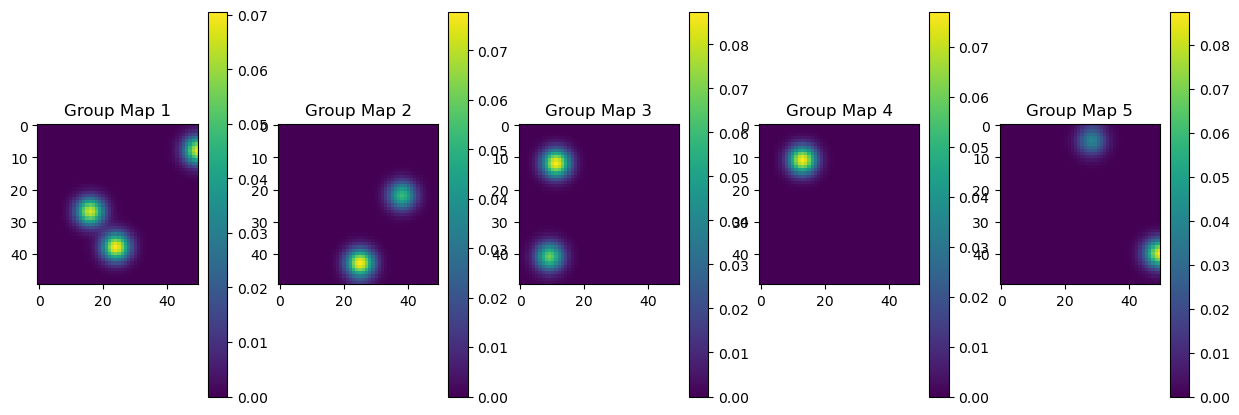

In [9]:
# Fonction pour générer une carte blob aléatoire
def generate_blob_map(grid_size, num_blobs, blob_std):
    """
    Génère une carte spatiale contenant des blobs aléatoires.

    Parameters:
        grid_size: int, taille de la grille (grid_size x grid_size).
        num_blobs: int, nombre de blobs à inclure.
        blob_std: float, écart-type pour le flou gaussien des blobs.

    Returns:
        numpy array de taille (grid_size, grid_size) représentant la carte.
    """
    map_grid = np.zeros((grid_size, grid_size))
    for _ in range(num_blobs):
        # Position aléatoire pour chaque blob
        x, y = np.random.randint(0, grid_size, size=2)
        map_grid[x, y] += np.random.uniform(1, 5)  # Amplitude du blob aléatoire

    # Lisser avec un filtre gaussien pour obtenir des blobs
    blob_map = gaussian_filter(map_grid, sigma=blob_std)
    return blob_map


# Paramètres de la simulation
S = 12  # Nombre de sujets
k = 5   # Nombre de cartes spatiales
n = 150 # Nombre de points temporels
p = 50  # Nombre de voxels (nous supposerons une grille 2D de p x p)


# Initialisation des cartes spatiales latentes V (groupe)
V_group = np.zeros((p, p, k))  # Chaque carte a une taille p x p

for i in range(k):
    # Générer une carte pour chaque composante spatiale avec 1 à 3 blobs
    V_group[:, :, i] = generate_blob_map(grid_size=p, num_blobs=np.random.randint(1, 4), blob_std=3.0)

# Initialisation des cartes spatiales sujet Vs
Vs_subjects = np.zeros((S, p, p, k))  # Taille : (S, p, p, k)

for s in range(S):
    for i in range(k):
        # Ajouter des variations individuelles aux cartes des sujets
        subject_variation = generate_blob_map(grid_size=p, num_blobs=np.random.randint(1, 3), blob_std=2.5)
        Vs_subjects[s, :, :, i] = V_group[:, :, i] + 0.1 * subject_variation  # Légères déformations

# Visualisation (facultatif)
plt.figure(figsize=(15, 5))
for i in range(k):
    plt.subplot(1, k, i + 1)
    plt.imshow(V_group[:, :, i], cmap="viridis")
    plt.title(f"Group Map {i + 1}")
    plt.colorbar()
plt.show()


In [10]:
# les méthodes de macha
smoothness = 2          # Smoothness in pixels (Gaussian filter sigma)


def generate_blob_map(map_size, num_blobs):
    """Generates a single map with the given number of blobs."""
    map_data = np.zeros(map_size)
    blobs = []
    
    for _ in range(num_blobs):
        # Randomly choose blob center and size
        center_x = np.random.randint(0, map_size[1])
        center_y = np.random.randint(0, map_size[0])
        radius = np.random.randint(5, 15)  # Random radius for blob
        
        # Avoid overlapping blobs
        for blob in blobs:
            dist = np.sqrt((center_x - blob[0])**2 + (center_y - blob[1])**2)
            if dist < radius + blob[2]:
                break
        else:
            blobs.append((center_x, center_y, radius))
            # Create a cone-shaped pattern
            for x in range(map_size[1]):
                for y in range(map_size[0]):
                    dist = np.sqrt((x - center_x)**2 + (y - center_y)**2)
                    if dist < radius:
                        map_data[y, x] += max(0, (1 - dist / radius))
    return map_data, blobs

def generate_latent_maps(num_maps, map_size, blob_trials, blob_prob, gaussian_jitter_std):
    """Generates multiple latent maps with blobs and subject-specific jitter , Vs pour un sujet ?"""
    maps = []
    all_blobs = []
    
    for _ in range(num_maps):
        # Number of blobs from binomial distribution
        num_blobs = binom.rvs(blob_trials, blob_prob)
        
        # Generate the base map
        base_map, blobs = generate_blob_map(map_size, num_blobs)
        maps.append(base_map)
        all_blobs.append(blobs)
    
    # Add Gaussian jitter to create subject-specific maps
    subject_maps = []
    for base_map, blobs in zip(maps, all_blobs):
        subject_map = np.copy(base_map)
        for blob in blobs:
            center_x, center_y, radius = blob
            
            # Apply Gaussian jitter
            jitter_x = int(np.random.normal(center_x, gaussian_jitter_std))
            jitter_y = int(np.random.normal(center_y, gaussian_jitter_std))
            jitter_radius = max(1, int(np.random.normal(radius, gaussian_jitter_std)))
            
            # Add jittered blob to the map
            for x in range(map_size[1]):
                for y in range(map_size[0]):
                    dist = np.sqrt((x - jitter_x)**2 + (y - jitter_y)**2)
                    if dist < jitter_radius:
                        subject_map[y, x] += max(0, (1 - dist / jitter_radius))
        
        subject_maps.append(subject_map)
    
    return maps, subject_maps

def generate_base_maps(num_maps, grid_size, blob_trials, blob_prob, blob_radius_range):
    """Generates shared population maps with smooth blobs , génerer V ?"""
    base_maps = []
    for _ in range(num_maps):
        map_data = np.zeros(grid_size)
        num_blobs = np.random.binomial(blob_trials, blob_prob)
        for _ in range(num_blobs):
            center_x = np.random.randint(0, grid_size[1])
            center_y = np.random.randint(0, grid_size[0])
            radius = np.random.randint(*blob_radius_range)
            for x in range(grid_size[1]):
                for y in range(grid_size[0]):
                    dist = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
                    if dist < radius:
                        map_data[y, x] += max(0, (1 - dist / radius))
        # Smooth the map using Gaussian filter
        base_maps.append(gaussian_filter(map_data, sigma=smoothness))
    return base_maps

def generate_subject_maps(base_maps, grid_size, jitter_std):
    """Adds subject-specific jitter to base maps."""
    subject_maps = []
    for base_map in base_maps:
        subject_map = np.zeros(grid_size)
        non_zero_coords = np.argwhere(base_map > 0)
        for coord in non_zero_coords:
            y, x = coord
            jittered_x = int(np.clip(np.random.normal(x, jitter_std), 0, grid_size[1] - 1))
            jittered_y = int(np.clip(np.random.normal(y, jitter_std), 0, grid_size[0] - 1))
            subject_map[jittered_y, jittered_x] += base_map[y, x]
        # Smooth the jittered map
        subject_maps.append(gaussian_filter(subject_map, sigma=smoothness))
    return subject_maps

def generate_time_series(subject_maps, time_points):
    """Generates a synthetic time series for each subject."""
    time_series = []
    for subject_map in subject_maps:
        series = np.zeros((time_points,) + subject_map.shape)
        for t in range(time_points):
            series[t] = subject_map + np.random.normal(0, 0.1, subject_map.shape)  # Add noise
        time_series.append(series)
    return np.array(time_series)

def generate_activations(num_subjects, num_activations,number_time_steps, activation_std):
    """Generates multi-variate gaussian activation maps for each subject."""
    activations = []
    for _ in range(num_subjects):
        activation_map = np.random.normal(0, activation_std, (num_activations, number_time_steps))
        activations.append(activation_map)
    return np.array(activations)

def generate_observations(activations,spatial_maps,noise_std):
    """Generates observed time series data from activations and spatial maps."""
    observations = []
    for activation, spatial_map in zip(activations, spatial_maps):
        multipl = activation.T@spatial_map
        observed_series = multipl + np.random.normal(0, noise_std, multipl.shape[1])
        observations.append(observed_series)
    return np.array(observations)

def flatten_matrix(matrix):
    """
    Flattens the last two dimensions of a matrix of any dimensionality.

    Args:
        matrix (numpy.ndarray): The input matrix to be flattened.

    Returns:
        numpy.ndarray: A matrix with the last two dimensions flattened.
    """
    # Ensure the input is a numpy array
    matrix = np.asarray(matrix)
    # Check if the matrix has at least two dimensions
    if matrix.ndim < 2:
        raise ValueError("Input matrix must have at least two dimensions to flatten the last two.")
    # Flatten the last two dimensions
    new_shape = matrix.shape[:-2] + (-1,)
    return matrix.reshape(new_shape)




In [11]:
# Parameters
num_subjects = 12       # Number of subjects
num_maps = 5            # Number of latent spatial maps
time_points = 150       # Number of time points
grid_size = (50, 50)    # Spatial grid size
smoothness = 2          # Smoothness in pixels (Gaussian filter sigma)
jitter_std = 3          # Jitter standard deviation in pixels
blob_trials = 3         # Binomial trials for blob count
blob_prob = 0.5         # Probability for blob success
blob_radius_range = (2, 5)  # Range of blob radii
inner_subject_variability = 0.1
inter_site_variability = 0.1

# Generate population maps
population_maps = generate_base_maps(num_maps, grid_size, blob_trials, blob_prob, blob_radius_range)

# Generate subject-specific maps for all subjects
subject_data = []
for _ in range(num_subjects):
    subject_data.append(generate_subject_maps(population_maps, grid_size, jitter_std))

# Generate time series
synthetic_time_series = [generate_time_series(subject_maps, time_points) for subject_maps in subject_data]



In [12]:
V = flatten_matrix(np.array(population_maps)) #  V
Vs = flatten_matrix(np.array(subject_data)) # Vs
Us = generate_activations(num_subjects, num_maps, time_points ,inner_subject_variability ) # Us
Ys = generate_observations(Us, Vs,inter_site_variability ) # Ys
V = V.transpose(1, 0)  # Change V from (5, 2500) to (2500, 5)
Vs = Vs.transpose(0, 2, 1)  # Change Vs from (12, 5, 2500) to (12, 2500, 5)
Us = Us.transpose(0, 2, 1)  # Change Us from (12, 5, 150) to (12, 150, 5
print("V shape is ",V.shape)
print("Vs shape is ",Vs.shape)
print("Us shape is : ",Us.shape)
print("Ys shape is :" ,Ys.shape)

V shape is  (2500, 5)
Vs shape is  (12, 2500, 5)
Us shape is :  (12, 150, 5)
Ys shape is : (12, 150, 2500)


In [23]:
V_estimated, Vs_estimated, U_estimated = MSDL_solving(Ys,k=5, V_init=V , mu=0.1 , lambd=0.1, epsilon=1e-4 , max_iter=50)

Iteration 1 , energy = 7424122.24827973
Iteration 2 , energy = 1764199.3049620076
Iteration 3 , energy = 8905258.362949075
Iteration 4 , energy = 5301401.807595231
Iteration 5 , energy = 9720851.149688562
Iteration 6 , energy = 6079492.287882128
Iteration 7 , energy = 189255.79103108367
Iteration 8 , energy = 679584.0729456899
Iteration 9 , energy = 1080128.6999242494
Iteration 10 , energy = 383493.4076499934
Iteration 11 , energy = 143596.2449759738
Iteration 12 , energy = 162197.49318727432
Iteration 13 , energy = 108189.54232230163
Iteration 14 , energy = 78788.48260276038
Iteration 15 , energy = 76207.13938761552
Iteration 16 , energy = 42486372.34903021
Iteration 17 , energy = 31972327.31414308
Iteration 18 , energy = 5294882.443529931
Iteration 19 , energy = 561503.9185486295
Iteration 20 , energy = 304410.77186327573
Iteration 21 , energy = 180390.79131481666
Iteration 22 , energy = 816358.7821523566
Iteration 23 , energy = 1408013.4325408477
Iteration 24 , energy = 1138527.2233

c:\Users\Sara Meziane\miniconda3\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


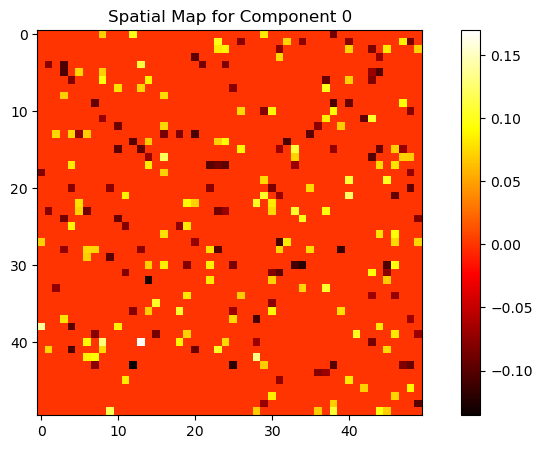

In [38]:
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

# --- Step 1: Preprocess the Data ---
def preprocess_data(Y):
    # Centering and normalizing each subject's data
    Y_centered = Y - Y.mean(axis=1, keepdims=True)  # Centering
    Y_normalized = Y_centered / Y.std(axis=1, keepdims=True)  # Normalizing
    return Y_normalized

# --- Step 2: Apply ICA ---
def apply_ica(Y, n_components):
    # Flatten the data: Combine all subjects
    Y_flat = Y.reshape(-1, Y.shape[-1])  # Shape: (12 * 150, 2500)
    
    # Apply FastICA
    ica = FastICA(n_components=n_components, random_state=42, max_iter=1000)
    S_ica = ica.fit_transform(Y_flat)  # Independent components (time courses)
    A_ica = ica.mixing_  # Mixing matrix (spatial maps)
    
    return S_ica, A_ica

# --- Step 3: Reshape Components Back ---
def reshape_components(S_ica, Y_shape, n_components):
    # Reshape time courses back to subject-level structure
    S_reshaped = S_ica.reshape(Y_shape[0], Y_shape[1], n_components)  # (12, 150, n_components)
    return S_reshaped

# --- Step 4: Threshold Spatial Maps ---
def threshold_maps(A_ica, threshold_percentile):
    # Compute the threshold based on percentile of absolute values
    threshold = np.percentile(np.abs(A_ica), threshold_percentile)
    
    # Apply the threshold
    A_thresholded = np.where(np.abs(A_ica) >= threshold, A_ica, 0)
    return A_thresholded

# --- Step 5: Visualize Components ---
def visualize_spatial_map(A_thresholded, component_idx, map_shape):
    # Visualize a specific spatial map
    plt.figure(figsize=(10, 5))
    plt.title(f"Spatial Map for Component {component_idx}")
    plt.imshow(A_thresholded[:, component_idx].reshape(map_shape), cmap="hot")
    plt.colorbar()
    plt.show()

# --- Main Script ---
if __name__ == "__main__":
    # Example input data
    Y = np.random.rand(12, 150, 2500)  # Replace with actual data
    
    # Parameters
    n_components = 50  # Number of ICA components
    threshold_percentile = 90  # Percentile for thresholding spatial maps
    map_shape = (50, 50)  # Shape of spatial maps (adjust based on data)
    
    # 1. Preprocess data
    Y_normalized = preprocess_data(Y)
    
    # 2. Apply ICA
    S_ica, A_ica = apply_ica(Y_normalized, n_components)
    
    # 3. Reshape components back
    S_reshaped = reshape_components(S_ica, Y.shape, n_components)
    
    # 4. Threshold spatial maps
    A_thresholded = threshold_maps(A_ica, threshold_percentile)
    
    # 5. Visualize an example spatial map
    visualize_spatial_map(A_thresholded, component_idx=0, map_shape=map_shape)


In [ ]:
from sklearn.decomposition import PCA
def subj_level_penal_mu(k,Y,Ys):
    for s in range(Y.shape[0]):
        pca = PCA(n_components=k)
        Y_s_reduced = pca.fit_transform(Y[s,;,;])  # Project to k-dimensional space
        Y_s_reconstructed = pca.inverse_transform(Y_s_reduced)  # Reconstruct from k components
        residuals = Y_s - Y_s_reconstructed
        residual_variance_e = np.var(residuals, ddof=1) 
        
        pca = PCA(n_components=k)
        Y_reduced = pca.fit_transform(Y)  # Project to k-dimensional space
        Y_reconstructed = pca.inverse_transform(Y_reduced)  # Reconstruct from k components
        residuals = Y - Y_reconstructed
        residual_variance_f = np.var(residuals, ddof=1) 
        
        s,n,p = Y.shape
        mu = (k/n)*(1/((residual_variance_f/(s*residual_variance_e))-1))
        return mu

In [ ]:


from sklearn.metrics import mean_squared_error
import numpy as np

def pop_level_penal_lambda(Y, Us, Vs, V, k=5, mu=1, lambd=1, epsilon=1e-4, n_splits=3):
    """
    Perform stratified cross-validation for the Multi-Subject Dictionary Learning model.

    Parameters:
    - Y: np.ndarray, shape (S, n, p), dataset for S subjects
    - Us: np.ndarray, shape (S, n, k), initial sparse codes for subjects
    - Vs: np.ndarray, shape (S, p, k), initial subject-specific dictionaries
    - V: np.ndarray, shape (p, k), initial global dictionary
    - k: int, number of atoms in the dictionary
    - mu: float, regularization parameter for subject-specific dictionaries
    - lambd: float, regularization parameter for global dictionary
    - epsilon: float, tolerance for convergence
    - n_splits: int, number of folds for stratified cross-validation

    Returns:
    - fold_errors: list, reconstruction error for each fold
    """
    S, n, p = Y.shape  
    fold_errors = []

    # Stratified K-Fold (applied to each subject individually)
    skf = StratifiedKFold(n_splits=n_splits)

    for fold_idx, (train_index, test_index) in enumerate(skf.split(np.zeros(n), np.zeros(n))):
        print(f"Fold {fold_idx + 1}/{n_splits}")
        reconstruction_error = 0 
        for s in range(S):
            Y_train, Y_test = Y[s, train_index, :], Y[s, test_index, :]
            Us_train, Us_test = Us[s, train_index, :], Us[s, test_index, :]

            V_estimated, Vs_estimated, U_estimated = MSDL_solving(
                Y_train, V_init=V, k=k, mu=mu, lambd=lambd, epsilon=epsilon
            )

            Y_reconstructed = np.dot(U_estimated, Vs_estimated.T)
            reconstruction_error += mean_squared_error(Y_test, Y_reconstructed)

        reconstruction_error /= S
        fold_errors.append(reconstruction_error)

    return fold_errors

optimal_lambda = None
min_error = float('inf')  # Initialize with a very high value
lambda_errors = []

for lambd in lambda_values:
    print(f"Testing lambda = {lambd}")
    fold_errors = pop_level_penal_lambda(Y, Us, Vs, V, k=10, mu=0.1, lambd=lambd, epsilon=1e-4, n_splits=5)
    average_error = np.mean(fold_errors)
    lambda_errors.append(average_error)
    print(f"Average Reconstruction Error for lambda {lambd}: {average_error}")

    if average_error < min_error:
        min_error = average_error
        optimal_lambda = lambd

print(f"Optimal lambda: {optimal_lambda}")
print(f"Minimum reconstruction error: {min_error}")